In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm # To see the time needed by loop for

import librosa as librosa #Python library for song analysis

from IPython.display import Audio #To play audio song

# Work with one song

48000


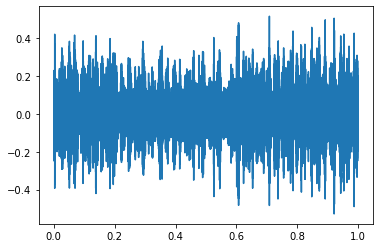

In [54]:
# We are loading one song and ploating the representation
# We are having a series of float who aren't usable in that state

rec, sr = librosa.load("rfcx-species-audio-detection/train/00ad36516.flac", sr=None)
plt.plot(np.linspace(0,1,len(rec)), rec)
print(sr)

In [163]:
# We will be able to ear a species during a short moment at a precise frequencies
# The time period and the frequencies where we can ear one species are given inside the training data

# We will first select a short period of our recording and listen to it

float_by_sec = int(len(rec)/60) #number of float representing one second of audio
s=0 # start of the short recording
rec_3sec = rec[s*float_by_sec:(s+3)*float_by_sec] # Short recording

Audio(data=rec_3sec,rate=sr)

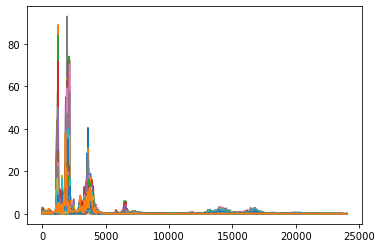

In [164]:
# Now we will use Fourier transformation to see the frequencies present inside rec_3sec
# Each color reprensent a really short period of time

n_fft = len(rec_3sec)
ft = librosa.stft(rec_3sec) 
plt.plot(librosa.fft_frequencies(sr=sr), abs(ft));

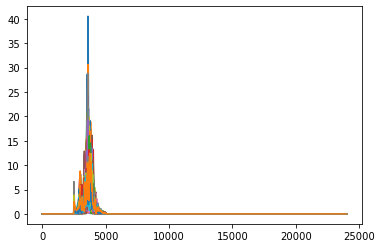

In [165]:
# We can see different elements who are constituing the audio
# Now let's focus on the peak between 2500 and 5000Hz

fmin = 2500 #Hz
fmax = 5000 #Hz

freq_int = [fmin < x < fmax for x in librosa.fft_frequencies(sr=sr)] 
ft_filter = np.array([ft[:,i]*freq_int for i in range(ft.shape[1])]).T # We are keeping only part of frequencies

plt.plot(librosa.fft_frequencies(sr=sr), abs(ft_filter)); # We can see that there is now only one peak

# We transform our filtered frequencies into a filtered recording
rec_filter = librosa.istft(ft_filter)

In [166]:
# Let's listen to the new recording
Audio(data=rec_filter,rate=sr)

In [167]:
# And to the original one, we can see that we were able to isolate one element
Audio(data=rec_3sec,rate=sr)

# Prediction on one species

In [65]:
# tp: species noise present during a specific moment of the recording
# fp: species noise not present during a specific moment of the recording (can still be present in the full recording)
data_train_tp_df = pd.read_csv("rfcx-species-audio-detection/train_tp.csv") 
data_train_fp_df = pd.read_csv("rfcx-species-audio-detection/train_fp.csv")

In [169]:
data_train_tp_df.songtype_id.value_counts() # Some species are different songtype, for the frst model 
                                            # we are only considering one songtype.

1    1088
4     128
Name: songtype_id, dtype: int64

In [5]:
data_train_tp_df.species_id.value_counts() # Number of values for each species

23    100
17     68
11     50
21     50
18     50
16     50
15     50
14     50
13     50
1      50
0      50
10     50
8      50
7      50
6      50
5      50
4      50
3      50
12     50
22     44
19     43
20     40
2      37
9      34
Name: species_id, dtype: int64

In [219]:
# This function corresponds to what was done on first part
# We are taking a recording and a range of frequencies in argument and returning a filtered recording

def freq_filter(rec, f_min, f_max, sr):
    ft = librosa.stft(rec) 
    freq_int = [f_min < x < f_max for x in librosa.fft_frequencies(sr=sr)]
    ft_filter = np.array([ft[:,i]*freq_int for i in range(ft.shape[1])]).T
    return librosa.istft(ft_filter)

In [278]:
# For the first model we will focus on the presence of species 0

# All recording are having the same sr, which will also us to use them more easily
_, native_sr = librosa.load("rfcx-species-audio-detection/train/0669568b1.flac", sr=None)

# True positive
data_train_tp0_df = data_train_tp_df[data_train_tp_df.species_id==17] # Data load for species 0
f_min = data_train_tp0_df.f_min.min() # We consider the min frequencies that we can find
f_max = data_train_tp0_df.f_max.max()

list_rec_tp = [] # We load the data inside this list
for i in tqdm(data_train_tp0_df.index):
    rec_id_i = data_train_tp0_df.loc[i].recording_id
    offset_i = data_train_tp0_df.loc[i].t_min
    duration_i = data_train_tp0_df.loc[i].t_max - offset_i
    rec_i = librosa.load("rfcx-species-audio-detection/train/{}.flac".format(rec_id_i), 
                                  sr=native_sr, offset=offset_i, duration=duration_i)[0] #Original recording
    list_rec_tp.append(freq_filter(rec_i, f_min, f_max, native_sr)) # We kept the filtered recording
    
    
# False positive
data_train_fp0_df = data_train_fp_df[data_train_fp_df.species_id==17]


list_rec_fp = []
for i in tqdm(data_train_fp0_df.index):
    rec_id_i = data_train_fp0_df.loc[i].recording_id
    offset_i = data_train_fp0_df.loc[i].t_min
    duration_i = data_train_fp0_df.loc[i].t_max - offset_i
    rec_i = librosa.load("rfcx-species-audio-detection/train/{}.flac".format(rec_id_i), 
                                  sr=native_sr, offset=offset_i, duration=duration_i)[0]
    list_rec_fp.append(freq_filter(rec_i, f_min, f_max, native_sr))


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [279]:
print('tp:',len(list_rec_tp),'; fp:',len(list_rec_fp)) # We are having more false positive than true positive

tp: 68 ; fp: 600


In [280]:
# We join the two list together and labeled if it's a tp or a fp

data0_df = pd.DataFrame(index=range(len(list_rec_tp+list_rec_fp)),columns=['rec','label'])

for i in range(len(list_rec_tp)):
    data0_df.rec[i]=list_rec_tp[i]
    data0_df.label[i]=1
    
for i in range(len(list_rec_fp)):
    data0_df.rec[i+len(list_rec_tp)]=list_rec_fp[i]
    data0_df.label[i+len(list_rec_tp)]=0
    
data0_df

,rec,label
0,"[-3.4173972e-05, -0.00019047102, -0.0005369616...",1
1,"[-0.0010748355, -0.0006674971, 0.00025264503, ...",1
2,"[0.0040398156, 0.0037386883, 0.0029537955, 0.0...",1
3,"[0.00085946417, 0.00046037755, -0.00045808556,...",1
4,"[-0.0049942676, -0.0046977513, -0.003929277, -...",1
...,...,...
663,"[0.0017320163, 0.0020689059, 0.00291344, 0.004...",0
664,"[-0.00700515, -0.0050270325, 0.00026439768, 0....",0
665,"[0.0014412918, 0.0015228866, 0.0015849569, 0.0...",0
666,"[-0.0011739157, -0.00096701476, -0.00024392686...",0


In [281]:
# Calculating mfcc for each recording

n_mfcc = 50

mfcc_tab=pd.DataFrame()
for i in range(len(data0_df)):
    mfcc_tab[i]=librosa.feature.mfcc(data0_df.rec[i],n_mfcc=n_mfcc).mean(axis=1)
#data0_df.columns = ['mfcc','label']
mfcc_tab = mfcc_tab.T

In [282]:
# Creating train and test data

from sklearn.model_selection import train_test_split

X=mfcc_tab
y=np.array(data0_df.label, dtype='bool')

X_train, X_test, y_train, y_test = train_test_split(X, y)

1.0

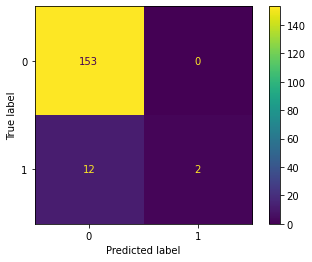

In [283]:
# Visualization of results for different metrics

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score

svc_clf = SVC()
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5)

clf = rf_clf
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict)).plot()
precision_score(y_test, y_predict)

# Prediction on a full recording

In [227]:
# Using the previous classifier we are going to predict if we can ear a species at any moment of one recording

rec_id = "000316da7"
full_rec, sr = librosa.load("rfcx-species-audio-detection/test/{}.flac".format(rec_id), sr=None, dtype='float32')

In [228]:
sec_len = int(len(full_rec)/60)
rec_2sec = [] # We will cut the recording in part of 2 seconds: 0-2; 1-3; etc.. and check them individually
for s in range(59): # The recording will start at 1 sec, ..., 58 sec
    rec_2sec.append(full_rec[s*sec_len:(s+2)*sec_len])

# Then we treat each part as before
gen_mfcc_2sec = (librosa.feature.mfcc(x,n_mfcc=n_mfcc).mean(axis=1) for x in rec_2sec)
mfcc_2sec = pd.DataFrame(gen_mfcc_2sec)

# And we look if in any of them we can ear the species
pred_rec = clf.predict_proba(mfcc_2sec)

print(pred_rec)

[[0.75766667 0.24233333]
 [0.76433333 0.23566667]
 [0.73433333 0.26566667]
 [0.73433333 0.26566667]
 [0.63933333 0.36066667]
 [0.74433333 0.25566667]
 [0.70433333 0.29566667]
 [0.69433333 0.30566667]
 [0.69433333 0.30566667]
 [0.68433333 0.31566667]
 [0.74433333 0.25566667]
 [0.73433333 0.26566667]
 [0.73433333 0.26566667]
 [0.76433333 0.23566667]
 [0.69433333 0.30566667]
 [0.73433333 0.26566667]
 [0.73933333 0.26066667]
 [0.75433333 0.24566667]
 [0.74433333 0.25566667]
 [0.73433333 0.26566667]
 [0.75433333 0.24566667]
 [0.69433333 0.30566667]
 [0.75433333 0.24566667]
 [0.73433333 0.26566667]
 [0.73433333 0.26566667]
 [0.71433333 0.28566667]
 [0.73433333 0.26566667]
 [0.73433333 0.26566667]
 [0.71433333 0.28566667]
 [0.71433333 0.28566667]
 [0.71433333 0.28566667]
 [0.71433333 0.28566667]
 [0.73433333 0.26566667]
 [0.74433333 0.25566667]
 [0.74433333 0.25566667]
 [0.83733333 0.16266667]
 [0.84666667 0.15333333]
 [0.84666667 0.15333333]
 [0.74433333 0.25566667]
 [0.72433333 0.27566667]


# Prediction on full test set for all species

In [229]:
# tp: species noise present during a specific moment of the recording
# fp: species noise not present during a specific moment of the recording (can still be present in the full recording)
data_train_tp_df = pd.read_csv("rfcx-species-audio-detection/train_tp.csv") 
data_train_fp_df = pd.read_csv("rfcx-species-audio-detection/train_fp.csv")

n_species = len(data_train_tp_df.species_id.value_counts().index) #Number of different species

In [230]:
# Get each recording interval (~1 second) with the presence or absence of the species

def load_training_data(species_id, data_tp_df, data_fp_df):
    #True positive
    data_train_tp_species_df = data_tp_df[data_tp_df.species_id==species_id]
    f_min = data_train_tp_species_df.f_min.min()
    f_max = data_train_tp_species_df.f_max.max()
    list_rec_tp = []
    for i in data_train_tp_species_df.index:
        rec_id_i = data_train_tp_species_df.loc[i].recording_id
        offset_i = data_train_tp_species_df.loc[i].t_min
        duration_i = data_train_tp_species_df.loc[i].t_max - offset_i
        rec_i = librosa.load("rfcx-species-audio-detection/train/{}.flac".format(rec_id_i), 
                            sr=native_sr, offset=offset_i, duration=duration_i)[0]
        list_rec_tp.append(freq_filter(rec_i, f_min, f_max, native_sr))
    
    #False positive
    data_train_fp_species_df = data_fp_df[data_fp_df.species_id==species_id]
    #We keep the same f_min and f_max as for tp
    list_rec_fp = []
    for i in data_train_fp_species_df.index:
        rec_id_i = data_train_fp_species_df.loc[i].recording_id
        offset_i = data_train_fp_species_df.loc[i].t_min
        duration_i = data_train_fp_species_df.loc[i].t_max - offset_i
        rec_i = librosa.load("rfcx-species-audio-detection/train/{}.flac".format(rec_id_i), 
                            sr=native_sr, offset=offset_i, duration=duration_i)[0]
        list_rec_fp.append(freq_filter(rec_i, f_min, f_max, native_sr))
    
    #Join and labelling
    data_species_df = pd.DataFrame(index=range(len(list_rec_tp+list_rec_fp)),columns=['rec','label'])
    for i in range(len(list_rec_tp)):
        data_species_df.rec[i]=list_rec_tp[i]
        data_species_df.label[i]=1
    for i in range(len(list_rec_fp)):
        data_species_df.rec[i+len(list_rec_tp)]=list_rec_fp[i]
        data_species_df.label[i+len(list_rec_tp)]=0
    
    return data_species_df

In [231]:
#Training of a RandomForestClassifier on all training data for each species

from sklearn.ensemble import RandomForestClassifier

list_clf=[]
for s_id in tqdm(range(n_species)):
    data_tr_df = load_training_data(s_id, data_train_tp_df, data_train_fp_df)

    n_mfcc = 50

    mfcc_tab_tr=pd.DataFrame()
    for i in range(len(data_tr_df)):
        mfcc_tab_tr[i]=librosa.feature.mfcc(data_tr_df.rec[i],n_mfcc=n_mfcc).mean(axis=1)
    mfcc_tab_tr = mfcc_tab_tr.T

    rf_clf = RandomForestClassifier(n_estimators=20, max_depth=10, min_samples_split=5)
    rf_clf.fit(mfcc_tab_tr, np.array(data_tr_df.label,dtype='bool'))
    list_clf.append(rf_clf)

  0%|          | 0/24 [00:00<?, ?it/s]

In [232]:
def cut_audio(path, len_cut=2): #Given a path to an audio file, return a list of len_cut seconds extract
    full_rec, sr = librosa.load(path) #Convert the audio into float
    float_by_sec = int(len(full_rec)/60) #number of float representing one second of audio
    rec_nsec=[]
    for s in range(61-len_cut): # The recording will start at 1 sec, ..., 60-len_cut sec
        rec_nsec.append(full_rec[s*float_by_sec:(s+len_cut)*float_by_sec])
    return rec_nsec

def gen_mfcc(rec_nsec):
    gen_mfcc_nsec = (librosa.feature.mfcc(x,n_mfcc=n_mfcc).mean(axis=1) for x in rec_nsec)
    return pd.DataFrame(gen_mfcc_nsec)

In [241]:
# We are loading each of our recording inside 2 second extracts

rec_test_id = pd.read_csv("rfcx-species-audio-detection/sample_submission.csv").recording_id

rec_list = []
for rec_id in tqdm(rec_test_id):
    path_rec_id = "rfcx-species-audio-detection/test/{}.flac".format(rec_id)
    rec_2sec = cut_audio(path_rec_id, len_cut=2)
    rec_list.append(rec_2sec)
    
rec_ser = pd.Series(rec_list, index = rec_test_id)

  0%|          | 0/1992 [00:00<?, ?it/s]

In [265]:
rec_ser.loc[rec_id]

[array([-0.00579518, -0.00564429, -0.00414267, ..., -0.00532689,
        -0.00079313,  0.00306264], dtype=float32),
 array([-0.00582276, -0.00450462, -0.00906635, ...,  0.01003366,
         0.013609  ,  0.01170008], dtype=float32),
 array([ 0.0046009 ,  0.00213479, -0.00038461, ...,  0.00069192,
         0.0018787 ,  0.00152058], dtype=float32),
 array([ 0.00782102, -0.00201233, -0.0021964 , ...,  0.00818032,
         0.01030653,  0.00806871], dtype=float32),
 array([ 0.0014394 , -0.00107978,  0.00174612, ...,  0.00136326,
        -0.00070907, -0.00304567], dtype=float32),
 array([ 6.7621707e-03, -1.3283789e-03, -6.6529945e-03, ...,
         3.8301092e-05, -2.2615059e-03,  9.2606124e-04], dtype=float32),
 array([-0.00209032,  0.00344706,  0.00450846, ...,  0.0016804 ,
         0.00215145,  0.00302262], dtype=float32),
 array([ 2.5444529e-03,  1.1673331e-03, -5.0786966e-03, ...,
         1.8945293e-03, -4.3510368e-05,  4.6675908e-04], dtype=float32),
 array([0.00850842, 0.00522425, 0.00

In [242]:
#Make predictions for each audio and each species

n_mfcc=50

prediction_df = pd.DataFrame(index=rec_test_id, columns=range(len(list_clf)))

for rec_id in tqdm(rec_ser.index):
    #path_rec_id = "rfcx-species-audio-detection/test/{}.flac".format(rec_id)
    #rec_2sec = cut_audio(path_rec_id, len_cut=2)
    
    rec_mfcc = gen_mfcc(rec_ser.loc[rec_id])
    
    for i in prediction_df.columns:
        prediction_df.loc[rec_id,i]=list_clf[i].predict_proba(rec_mfcc)[:,1].max()

  0%|          | 0/1992 [00:00<?, ?it/s]

In [246]:
#Change prediction_df inside expected format for result submission, to be run only once

new_cols=[]
for i in prediction_df.columns:
    new_cols.append('s'+str(i))
    
prediction_df.columns = new_cols
prediction_df.reset_index(inplace=True)

In [258]:
#And save the file for submission

prediction_df.to_csv('prediction_new.csv', index=False)

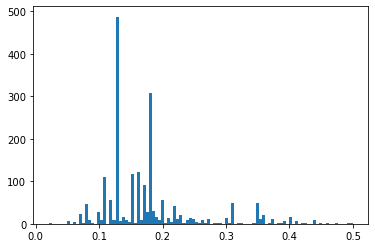

In [276]:
plt.hist(prediction_df.s17,100);